# Drogenpolitik

Ermittlungsverfahren Staatsanwaltschaften: Daten von 2010 - 2013:
https://www.destatis.de/DE/Publikationen/Thematisch/Rechtspflege/AlteAusgaben/StaatsanwaltschaftenAlt.html


In [2]:
from __future__ import division

import sys
reload(sys)
sys.setdefaultencoding("utf-8")

from datetime import datetime
from functools import wraps
import itertools

%pylab inline
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame, Series
import pandas as pd
import statsmodels.api as sm

import seaborn as sns


In [3]:
# Clean the whole mess up

from csvkit import convert
import unicodecsv

from StringIO import StringIO

OLGS = {
    u'Karlsruhe': u'Baden-Württemberg',
    u'Stuttgart': u'Baden-Württemberg',
    u'M\xfcnchen': u'Bayern',
    u'N\xfcrnberg': u'Bayern',
    u'Bamberg': u'Bayern',
    u'Braunschweig': u'Niedersachsen',
    u'Celle': u'Niedersachsen',
    u'Oldenburg': u'Niedersachsen',
    u'D\xfcsseldorf': u'Nordrhein-Westfalen',
    u'Hamm': u'Nordrhein-Westfalen',
    u'K\xf6ln': u'Nordrhein-Westfalen',
    u'Koblenz': u'Rheinland-Pfalz',
    u'Zweibr\xfccken': u'Rheinland-Pfalz',
}

def convert_sheet(filename, sheet, columns):
    xl_file = open(filename, 'rb')
    data = convert.convert(xl_file, filename.rsplit('.', 1)[1], sheet=sheet)
    csv_file = StringIO(data)
    last_label = None
    last_num = None
    for i, line in enumerate(unicodecsv.reader(csv_file)):
        if i < 13:
            continue

        line = [l.strip() for l in line]
        line[2:] = [l.replace(' ', '').replace('-','0') for l in line[2:]]
        if 'Prozent' in line:
            return
        if '__' in line[0]:
            return
        if line[2] == '':
            last_label = line[1]
            last_num = line[0]
            continue
        if last_label is not None:
            line[1] = '%s %s' % (last_label, line[1])
            last_label = None
        if last_num is not None and line[0] == '':
            line[0] = last_num
            last_num = None
        if line[0] == '':
            return
        yield {k: v for k, v in zip(columns, line) if k}


def write_dicts(filename, dict_gen):
    writer = None
    fields = ('lfdnr', 'einleitungsart', 'bundesland', 'olg', 'anzahl')
    writer = unicodecsv.DictWriter(open(filename, 'w'), fields)
    writer.writeheader()
    for line in dict_gen:
        out = {}
        for k, v in line.items():
            if k[0].lower() == k[0]:
                out[k] = v
        for k, v in line.items():
            if k[0].lower() == k[0]:
                continue
            current_out = dict(out)
            current_out['anzahl'] = v
            if k in OLGS:
                current_out['bundesland'] = OLGS[k]
                current_out['olg'] = k
            else:
                if k in OLGS.values():
                    continue
                current_out['bundesland'] = k
                current_out['olg'] = k
            writer.writerow(current_out)


In [4]:
# Write everything out to clean CSV
topics = {
    'missbrauch': ('Tab3_1_1', u'Straftaten gegen die sexuelle Selbstbestimmung'),
    'koerperverletzung': ('Tab3_2_1', u'Vorsätzliche Körperverletzung'),
    'diebstahl': ('Tab3_3_1', u'Diebstahl und Unterschlagung'),
    'betrug': ('Tab3_4_1', u'Betrug und Untreue'),
    'strassenverkehr': ('Tab3_5_1', u'Straftaten im Straßenverkehr'),
    'wirtschaft': ('Tab3_6_1', u'Wirtschafts- und Steuerstraftaten, Geldwäschedelikte'),
    'wirtschaft': ('Tab3_6_1', u'Wirtschafts- und Steuerstraftaten, Geldwäschedelikte'),
    'drogen': ('Tab3_7_1', u'Straftaten nach dem Betäubungsmittelgesetz'),
}
years = range(2010, 2014)
columns = [u'lfdnr', u'einleitungsart', u'', u'Baden-Württemberg', u'Karlsruhe', u'Stuttgart', u'Bayern', u'M\xfcnchen', u'N\xfcrnberg', u'Bamberg', u'Berlin', u'Brandenburg', u'Bremen', u'Hamburg', u'Hessen', u'', u'', u'', u'Mecklenburg-Vorpommern', u'Niedersachsen', u'Braunschweig', u'Celle', u'Oldenburg', u'Nordrhein-Westfalen', u'D\xfcsseldorf', u'Hamm', u'K\xf6ln', u'Rheinland-Pfalz', u'Koblenz', u'Zweibr\xfccken', u'Saarland', u'Sachsen', u'Sachsen-Anhalt', u'Schleswig-Holstein', u'Thüringen', u'']
old_columns = columns[:2] + ['', ''] + columns[2:]
for topic in topics:
    write_dicts('erledigte_verfahren/%s_2013.csv' % topic, convert_sheet("erledigte_verfahren/Staatsanwaltschaften2100260137005.xlsx", topics[topic][0], columns))
    write_dicts('erledigte_verfahren/%s_2012.csv' % topic, convert_sheet("erledigte_verfahren/Staatsanwaltschaften2100260127005.xls", topics[topic][0], columns))
    write_dicts('erledigte_verfahren/%s_2011.csv' % topic, convert_sheet("erledigte_verfahren/Staatsanwaltschaften2100260117005.xls", topics[topic][0], old_columns))
    write_dicts('erledigte_verfahren/%s_2010.csv' % topic, convert_sheet("erledigte_verfahren/Staatsanwaltschaften2100260107005.xls", topics[topic][0], old_columns))


In [5]:
# Read everything back into one DataFrame
df = DataFrame()

def get_merged_df():
    for year in years:
        for topic in topics:
            tmp_frame = pd.read_csv('erledigte_verfahren/%s_%s.csv' % (topic, year), encoding='utf-8')
            tmp_frame['year'] = year
            tmp_frame['topic'] = topic
            yield tmp_frame

df = pd.concat(get_merged_df())

## Top-Bereiche von eingestellte Verfahren

Eingestellt ohne Auflage gemäß... (lfd-nr 18) + § 170 (lfdnr 21).

In [6]:
#   Einstellung ohne Auflage gemäß §§ 153, 153b und c, 154 Abs.1 und
eingestellt_1 = df.groupby(('year', 'topic', 'lfdnr')).sum().query('lfdnr == 18')
#   Einstellung gemäß § 170 Abs. 2 StPO 
eingestellt_2 = df.groupby(('year', 'topic', 'lfdnr')).sum().query('lfdnr == 21')
#   Einstellung mit Auflage
# eingestellt_3 = df.groupby(('year', 'topic', 'lfdnr')).sum().query('lfdnr == 14')

total = df.groupby(('year', 'topic', 'lfdnr')).sum().query('lfdnr == 1')
eingestellt_1 = eingestellt_1.reset_index()
eingestellt_2 = eingestellt_2.reset_index()
# eingestellt_3 = eingestellt_3.reset_index()
total = total.reset_index()

eingestellt = eingestellt_1['anzahl'] + eingestellt_2['anzahl'] # + eingestellt_3['anzahl']

total['eingestellt'] = eingestellt
total['ratio'] = eingestellt / total['anzahl']
total.sort('ratio', ascending=False)

,year,topic,lfdnr,anzahl,eingestellt,ratio
23,2013,drogen,1,283545,181922,0.641598
16,2012,drogen,1,258440,161776,0.625971
9,2011,drogen,1,259014,160383,0.619206
11,2011,missbrauch,1,52686,32124,0.609726
18,2012,missbrauch,1,50614,30409,0.600802
2,2010,drogen,1,254604,152833,0.600277
4,2010,missbrauch,1,53974,31865,0.590377
25,2013,missbrauch,1,53635,31117,0.580162
22,2013,diebstahl,1,668600,371217,0.555215
24,2013,koerperverletzung,1,429668,237779,0.553402


In [15]:
drogen_years = total[total.topic == 'drogen'].groupby('year')['anzahl'].sum()
drogen_years

year
2010    254604
2011    259014
2012    258440
2013    283545
Name: anzahl, dtype: float64

([<matplotlib.axis.XTick at 0x10932ccd0>,
 <a list of 3 Text xticklabel objects>)

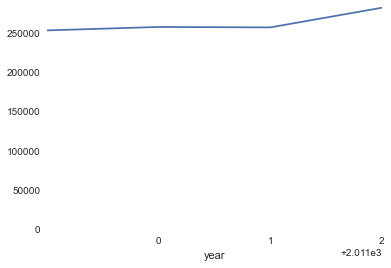

In [17]:
drogen_years.plot()
plt.ylim(0)
plt.xticks(range(2011, 2014))

(0, 0.65000000000000013)

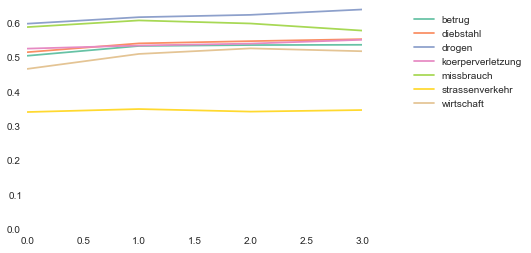

In [28]:
colors = sns.color_palette("Set2", 16)
year_topics = total.set_index('year')
grouped = year_topics.groupby('topic')
for i, (key, group) in enumerate(grouped):
    plt.plot(group['ratio'], c=colors[i], ls='-', label=key)
plt.legend(bbox_to_anchor=[1.5, 1])
plt.ylim(0)